# Signal correction and CDS recovery

Now let's implement the signal correction steps described in the [Calibrating and Binning Ariel Data](https://www.kaggle.com/code/gordonyip/calibrating-and-binning-ariel-data) notebooks from the competition organizers. Here are the steps:

1. Analog-to-Digital Conversion
2. Mask hot/dead pixel
3. Linearity Correction
4. Dark current subtraction
5. Get Correlated Double Sampling (CDS)
6. Flat Field Correction

## Notebook set-up

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


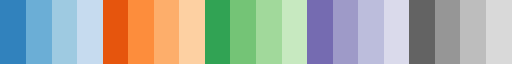

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
import itertools
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import colormaps as cm

from astropy.stats import sigma_clip

# Local imports
import configuration as config

# Make sure output directory for figures exists
figures_dir = f'{config.FIGURES_DIRECTORY}/signal_correction'
Path(figures_dir).mkdir(parents=True, exist_ok=True)

config.COLORMAP

## 1. Load assets

### 1.1. Signal data

In [2]:
# Define file paths for signal data
airs_file = f'{config.RAW_DATA_DIRECTORY}/train/{config.SAMPLE_PLANET}/AIRS-CH0_signal_0.parquet'
fgs_file = f'{config.RAW_DATA_DIRECTORY}/train/{config.SAMPLE_PLANET}/FGS1_signal_0.parquet'

# Load and reshape the AIRS-CH0 data into 3D array (frames, rows, cols)
airs_signal = pd.read_parquet(airs_file).to_numpy().reshape(11250, 32, 356).astype(np.float64)

# Crop AIRS-CH0 data to match wavelength indices (remove unused columns)
cut_inf, cut_sup = 39, 321
airs_signal = airs_signal[:, :, cut_inf:cut_sup]

# Load and reshape the FGS1 data into 3D array (frames, rows, cols)
fgs_signal = pd.read_parquet(fgs_file).to_numpy().reshape(135000, 32, 32).astype(np.float64)

### 1.2. Signal correction data

In [3]:
# Load axis information for timing data
axis_info = pd.read_parquet(f'{config.DATA_DIRECTORY}/raw/axis_info.parquet')

# Define planet calibration data path
planet_path = f'{config.RAW_DATA_DIRECTORY}/train/{config.SAMPLE_PLANET}'

# Load AIRS-CH0 calibration data
dark_airs = pd.read_parquet(
    f'{planet_path}/AIRS-CH0_calibration_0/dark.parquet'
).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]

dead_airs = pd.read_parquet(
    f'{planet_path}/AIRS-CH0_calibration_0/dead.parquet'
).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]

# Load FGS1 calibration data
dark_fgs = pd.read_parquet(
    f'{planet_path}/FGS1_calibration_0/dark.parquet'
).values.astype(np.float64).reshape((32, 32))

dead_fgs = pd.read_parquet(
    f'{planet_path}/FGS1_calibration_0/dead.parquet'
).values.astype(np.float64).reshape((32, 32))

# Load linearity correction coefficients for AIRS-CH0
airs_linear_corr = pd.read_parquet(
    f'{planet_path}/AIRS-CH0_calibration_0/linear_corr.parquet'
).values.astype(np.float64).reshape((6, 32, 356))[:, :, cut_inf:cut_sup]

# Load linearity correction coefficients for FGS1
linear_corr = pd.read_parquet(
    f'{planet_path}/FGS1_calibration_0/linear_corr.parquet'
).values.astype(np.float64).reshape((6, 32, 32))

# Load flat field calibration data
airs_flat = pd.read_parquet(
    f'{planet_path}/AIRS-CH0_calibration_0/flat.parquet'
).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]

fgs_flat = pd.read_parquet(
    f'{planet_path}/FGS1_calibration_0/flat.parquet'
).values.astype(np.float64).reshape((32, 32))

## 2. Preprocessing & CDS recovery

In [4]:
# Select a sample frame for step-by-step visualization
sample_frame = 5
airs_sample_frames = []
fgs_sample_frames = []

# Store initial uncorrected frames for comparison
airs_sample_frames.append(airs_signal[sample_frame])
fgs_sample_frames.append(fgs_signal[sample_frame])

### 2.1. Analog-to-Digital Conversion

Here are the ADC values from the `adc_info.csv` data file:

```
FGS1_adc_offset,FGS1_adc_gain,AIRS-CH0_adc_offset,AIRS-CH0_adc_gain
-1000.0,0.4369,-1000.0,0.4369
```

In [5]:
# Function to perform Analog-to-Digital Conversion
def ADC_convert(signal, gain=0.4369, offset=-1000):

    signal = signal.astype(np.float64)
    signal /= gain  # Apply gain correction
    signal += offset  # Apply offset correction

    return signal

In [6]:
# Apply ADC conversion to both instrument signals
airs_signal = ADC_convert(airs_signal)
fgs_signal = ADC_convert(fgs_signal)

# Store converted frames for visualization
airs_sample_frames.append(airs_signal[sample_frame])
fgs_sample_frames.append(fgs_signal[sample_frame])

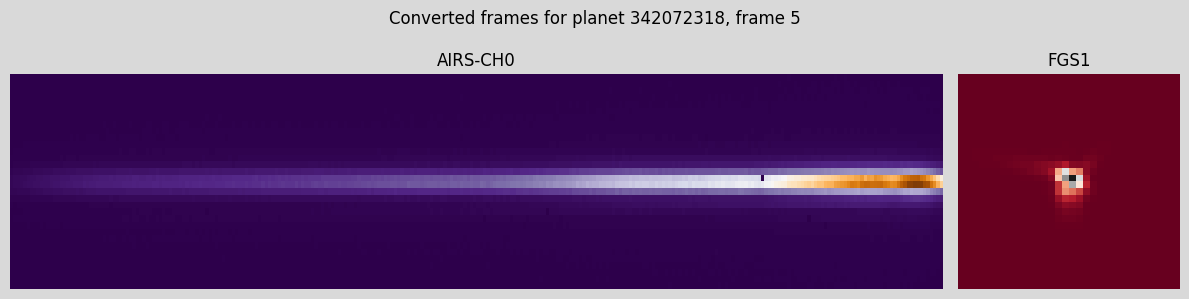

In [7]:
# Visualize the ADC converted frames
fig = plt.figure(figsize=(12, 3))

fig.suptitle(f'Converted frames for planet {config.SAMPLE_PLANET}, frame {sample_frame}')
fig.patch.set_facecolor(config.LIGHT_LIGHTER_GRAY)

# Create subplot layout with different aspect ratios for AIRS and FGS
gs = fig.add_gridspec(1,5)
ax1 = fig.add_subplot(gs[0, :4])  # Wider subplot for AIRS
ax2 = fig.add_subplot(gs[0, 4])   # Square subplot for FGS

# Display AIRS-CH0 frame
ax1.set_title(f'AIRS-CH0')
ax1.imshow(airs_sample_frames[1], aspect='auto', cmap=config.AIRS_HEATMAP_CMAP)
ax1.axis('off')

# Display FGS1 frame
ax2.set_title('FGS1')
ax2.imshow(fgs_sample_frames[1], aspect='auto', cmap=config.FGS1_HEATMAP_CMAP)
ax2.axis('off')

fig.tight_layout()
fig.savefig(
    f'{figures_dir}/02.1.1-converted_sample_frames.jpg',
    dpi=config.STD_FIG_DPI, bbox_inches='tight'
)

### 2.2. Hot/dead pixel mask

In [8]:
# Function to mask hot and dead pixels
def mask_hot_dead(signal, dead, dark):

    # Identify hot pixels using sigma clipping on dark frames
    hot = sigma_clip(
        dark, sigma=5, maxiters=5
    ).mask
    
    # Broadcast masks to match signal dimensions
    hot = np.tile(hot, (signal.shape[0], 1, 1))
    dead = np.tile(dead, (signal.shape[0], 1, 1))
    
    # Apply masks to create masked arrays
    signal = np.ma.masked_where(dead, signal)
    signal = np.ma.masked_where(hot, signal)

    return signal

In [9]:
# Apply hot/dead pixel masking to both instruments
airs_signal = mask_hot_dead(airs_signal, dead_airs, dark_airs)
fgs_signal = mask_hot_dead(fgs_signal, dead_fgs, dark_fgs)

# Store masked frames for visualization
airs_sample_frames.append(airs_signal[sample_frame])
fgs_sample_frames.append(fgs_signal[sample_frame])

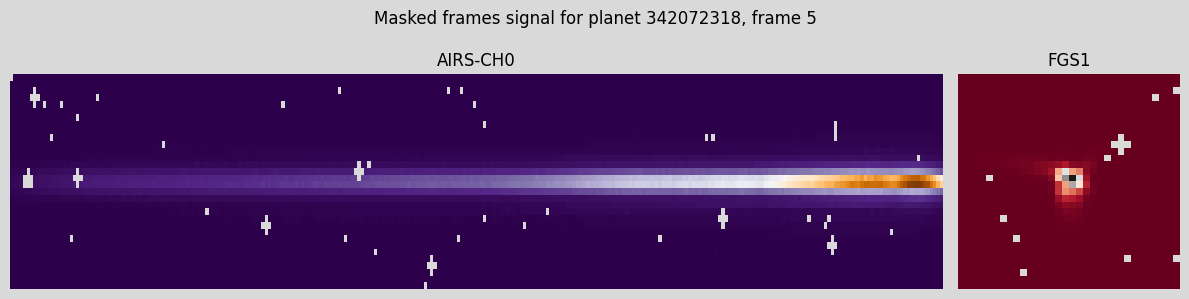

In [10]:
# Visualize the masked frames
fig = plt.figure(figsize=(12, 3))

fig.suptitle(f'Masked frames signal for planet {config.SAMPLE_PLANET}, frame {sample_frame}')
fig.patch.set_facecolor(config.LIGHT_LIGHTER_GRAY)

# Create subplot layout
gs = fig.add_gridspec(1,5)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4])

# Display AIRS-CH0 masked frame
ax1.set_title(f'AIRS-CH0')
ax1.imshow(airs_sample_frames[2], aspect='auto', cmap=config.AIRS_HEATMAP_CMAP)
ax1.axis('off')

# Display FGS1 masked frame
ax2.set_title('FGS1')
ax2.imshow(fgs_sample_frames[2], aspect='auto', cmap=config.FGS1_HEATMAP_CMAP)
ax2.axis('off')

fig.tight_layout()
fig.savefig(
    f'{figures_dir}/02.1.2-masked_sample_frames.jpg',
    dpi=config.STD_FIG_DPI, bbox_inches='tight'
)

### 2.3. Linearity correction

In [11]:
# Function to apply linearity correction using polynomial coefficients
def apply_linear_corr(linear_corr, clean_signal):
    
    # Flip coefficients to correct order for numpy polynomial
    linear_corr = np.flip(linear_corr, axis=0)
    
    # Apply pixel-wise polynomial correction
    for x, y in itertools.product(
                range(clean_signal.shape[1]), range(clean_signal.shape[2])
            ):
        # Create polynomial from coefficients and apply to pixel time series
        poli = np.poly1d(linear_corr[:, x, y])
        clean_signal[:, x, y] = poli(clean_signal[:, x, y])

    return clean_signal

In [12]:
# Apply linearity correction to both instruments
airs_signal = apply_linear_corr(airs_linear_corr, airs_signal)
fgs_signal = apply_linear_corr(linear_corr, fgs_signal)

# Store linearity corrected frames for visualization
airs_sample_frames.append(airs_signal[sample_frame])
fgs_sample_frames.append(fgs_signal[sample_frame])

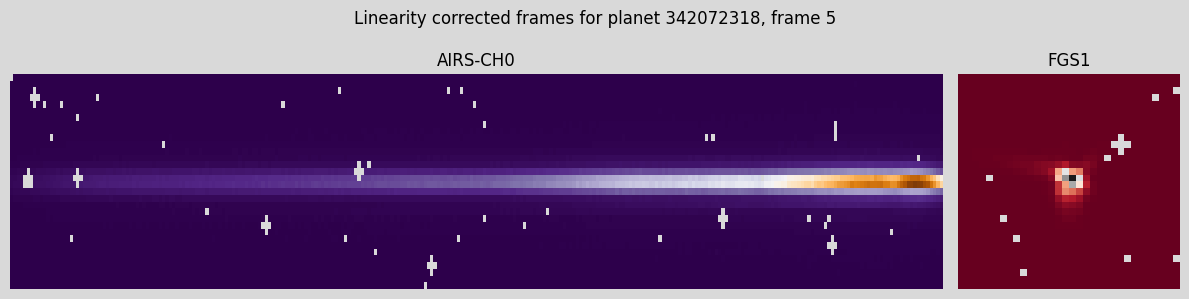

In [13]:
# Visualize the linearity corrected frames
fig = plt.figure(figsize=(12, 3))

fig.suptitle(f'Linearity corrected frames for planet {config.SAMPLE_PLANET}, frame {sample_frame}')
fig.patch.set_facecolor(config.LIGHT_LIGHTER_GRAY)

# Create subplot layout
gs = fig.add_gridspec(1,5)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4])

# Display AIRS-CH0 linearity corrected frame
ax1.set_title(f'AIRS-CH0')
ax1.imshow(airs_sample_frames[3], aspect='auto', cmap=config.AIRS_HEATMAP_CMAP)
ax1.axis('off')

# Display FGS1 linearity corrected frame
ax2.set_title('FGS1')
ax2.imshow(fgs_sample_frames[3], aspect='auto', cmap=config.FGS1_HEATMAP_CMAP)
ax2.axis('off')

fig.tight_layout()
fig.savefig(
    f'{figures_dir}/02.1.3-linearity_corrected_sample_frames.jpg',
    dpi=config.STD_FIG_DPI, bbox_inches='tight'
)

### 2.4. Dark current subtraction

In [14]:
# Function to subtract dark current scaled by integration time
def clean_dark(signal, dead, dark, dt):

    # Mask dark frame using dead pixel mask
    dark = np.ma.masked_where(dead, dark)
    # Broadcast dark frame to match signal dimensions
    dark = np.tile(dark, (signal.shape[0], 1, 1))

    # Subtract dark current scaled by integration time
    signal -= dark* dt[:, np.newaxis, np.newaxis]

    return signal

In [15]:
# Get integration times from axis info
dt_airs = axis_info['AIRS-CH0-integration_time'].dropna().values
dt_airs[1::2] += 0.1 # Why are we adding here - I don't think that is right...

# Set FGS1 integration times (shorter exposures)
dt_fgs = np.ones(len(fgs_signal))*0.1
dt_fgs[1::2] += 0.1 # This one looks more correct

Gotta double check my reading of the exposure kinetics again...

In [16]:
airs_signal = clean_dark(airs_signal, dead_airs, dark_airs, dt_airs)
fgs_signal = clean_dark(fgs_signal, dead_fgs, dark_fgs, dt_fgs)

airs_sample_frames.append(airs_signal[sample_frame])
fgs_sample_frames.append(fgs_signal[sample_frame])

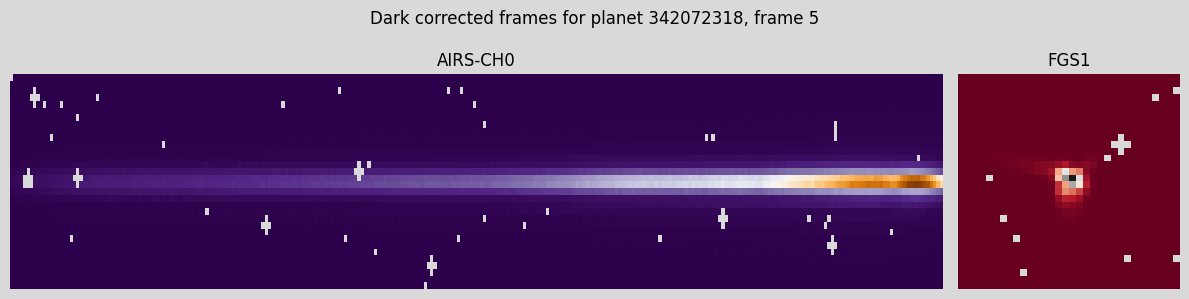

In [17]:
fig = plt.figure(figsize=(12, 3))

fig.suptitle(f'Dark corrected frames for planet {config.SAMPLE_PLANET}, frame {sample_frame}')
fig.patch.set_facecolor(config.LIGHT_LIGHTER_GRAY)

gs = fig.add_gridspec(1,5)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4])

ax1.set_title(f'AIRS-CH0')
ax1.imshow(airs_sample_frames[4], aspect='auto', cmap=config.AIRS_HEATMAP_CMAP)
ax1.axis('off')

ax2.set_title('FGS1')
ax2.imshow(fgs_sample_frames[4], aspect='auto', cmap=config.FGS1_HEATMAP_CMAP)
ax2.axis('off')

fig.tight_layout()
fig.savefig(
    f'{figures_dir}/02.1.4-dark_corrected_sample_frames.jpg',
    dpi=config.STD_FIG_DPI, bbox_inches='tight'
)

### 2.5. Get Correlated Double Sampling (CDS)

In [18]:
def get_cds(signal):
    cds = signal[1::2,:,:] - signal[::2,:,:]

    return cds

In [19]:
sample_frame = 3

airs_signal = get_cds(airs_signal)
fgs_signal = get_cds(fgs_signal)

airs_sample_frames.append(airs_signal[sample_frame])
fgs_sample_frames.append(fgs_signal[sample_frame])

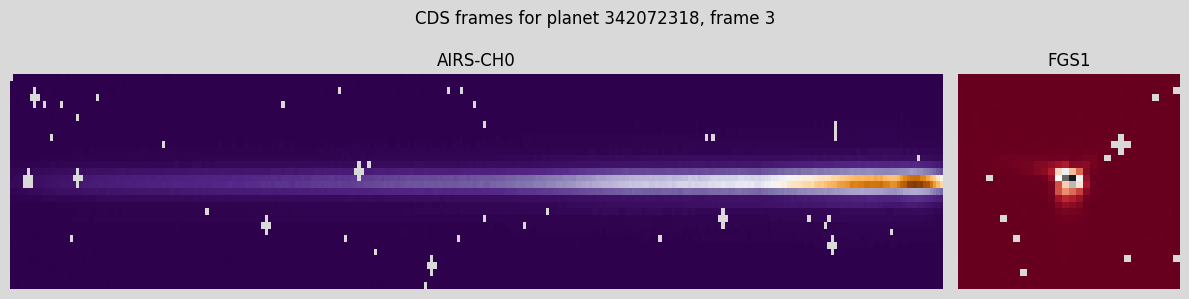

In [20]:
fig = plt.figure(figsize=(12, 3))

fig.suptitle(f'CDS frames for planet {config.SAMPLE_PLANET}, frame {sample_frame}')
fig.patch.set_facecolor(config.LIGHT_LIGHTER_GRAY)

gs = fig.add_gridspec(1,5)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4])

ax1.set_title(f'AIRS-CH0')
ax1.imshow(airs_sample_frames[5], aspect='auto', cmap=config.AIRS_HEATMAP_CMAP)
ax1.axis('off')

ax2.set_title('FGS1')
ax2.imshow(fgs_sample_frames[5], aspect='auto', cmap=config.FGS1_HEATMAP_CMAP)
ax2.axis('off')

fig.tight_layout()
fig.savefig(
    f'{figures_dir}/02.1.5-CDS_sample_frames.jpg',
    dpi=config.STD_FIG_DPI, bbox_inches='tight'
)

### 2.6. Flat field correction

In [21]:
def correct_flat_field(flat, dead, signal):

    flat = flat.transpose(1, 0)
    dead = dead.transpose(1, 0)
    flat = np.ma.masked_where(dead, flat)
    flat = np.tile(flat, (signal.shape[0], 1, 1))
    signal = signal / flat

    return signal

In [22]:
airs_signal = airs_signal.transpose(0,2,1)
fgs_signal = fgs_signal.transpose(0,2,1)

airs_signal = correct_flat_field(airs_flat, dead_airs, airs_signal)
fgs_signal = correct_flat_field(fgs_flat, dead_fgs, fgs_signal)

airs_signal = airs_signal.transpose(0,2,1)
fgs_signal = fgs_signal.transpose(0,2,1)

airs_sample_frames.append(airs_signal[sample_frame])
fgs_sample_frames.append(fgs_signal[sample_frame])

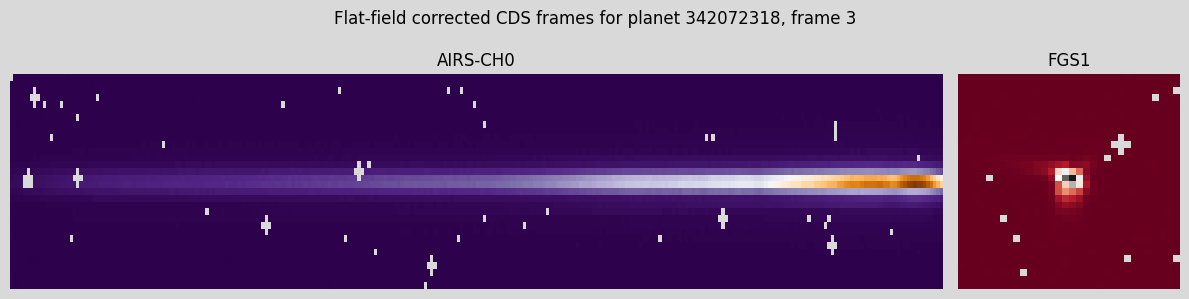

In [23]:
fig = plt.figure(figsize=(12, 3))

fig.suptitle(f'Flat-field corrected CDS frames for planet {config.SAMPLE_PLANET}, frame {sample_frame}')
fig.patch.set_facecolor(config.LIGHT_LIGHTER_GRAY)

gs = fig.add_gridspec(1,5)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4])

ax1.set_title(f'AIRS-CH0')
ax1.imshow(airs_sample_frames[6], aspect='auto', cmap=config.AIRS_HEATMAP_CMAP)
ax1.axis('off')

ax2.set_title('FGS1')
ax2.imshow(fgs_sample_frames[6], aspect='auto', cmap=config.FGS1_HEATMAP_CMAP)
ax2.axis('off')

fig.tight_layout()
fig.savefig(
    f'{figures_dir}/02.1.6-flat_corrected_CDS_sample_frames.jpg',
    dpi=config.STD_FIG_DPI, bbox_inches='tight'
)

## 4. Diagnostic plots

OK, *now* plot...

### 4.1. Signal correction steps

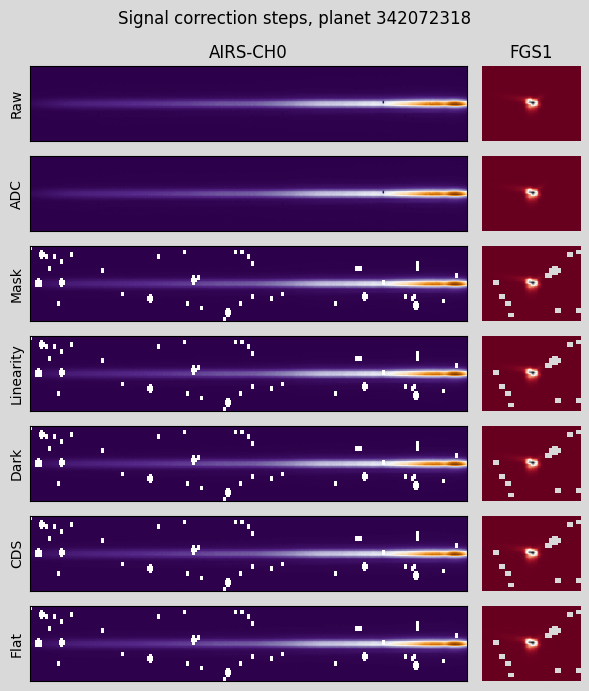

In [24]:
# Plot the first few frames
steps = ['Raw','ADC','Mask','Linearity','Dark','CDS','Flat']
n_frames = len(airs_sample_frames)

fig = plt.figure(figsize=(config.STD_FIG_WIDTH, n_frames))
fig.suptitle(f'Signal correction steps, planet {config.SAMPLE_PLANET}')
fig.patch.set_facecolor(config.LIGHT_LIGHTER_GRAY)

gs = fig.add_gridspec(n_frames, 5)
airs_axs = []
fgs_axs = []

for i in range(n_frames):

    airs_axs.append(fig.add_subplot(gs[i, :4]))
    fgs_axs.append(fig.add_subplot(gs[i, 4]))

    airs_axs[i].imshow(airs_sample_frames[i], aspect='auto', cmap=config.AIRS_HEATMAP_CMAP)      
    airs_axs[i].axes.get_xaxis().set_ticks([])
    airs_axs[i].axes.get_yaxis().set_ticks([])
    airs_axs[i].set_ylabel(steps[i])

    fgs_axs[i].imshow(fgs_sample_frames[i], aspect='auto', cmap=config.FGS1_HEATMAP_CMAP)      
    fgs_axs[i].axis('off')

airs_axs[0].set_title('AIRS-CH0')
fgs_axs[0].set_title('FGS1')

fig.tight_layout()

fig.savefig(
    f'{figures_dir}/02.1.7-signal_correction_steps.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

Much better! Those blobs are the hot/dead pixels that have been masked out. How does the transit look in the FGS data?

### 4.2. Exoplanet transits

What about the transit signal in the AIRS-CH0 data?

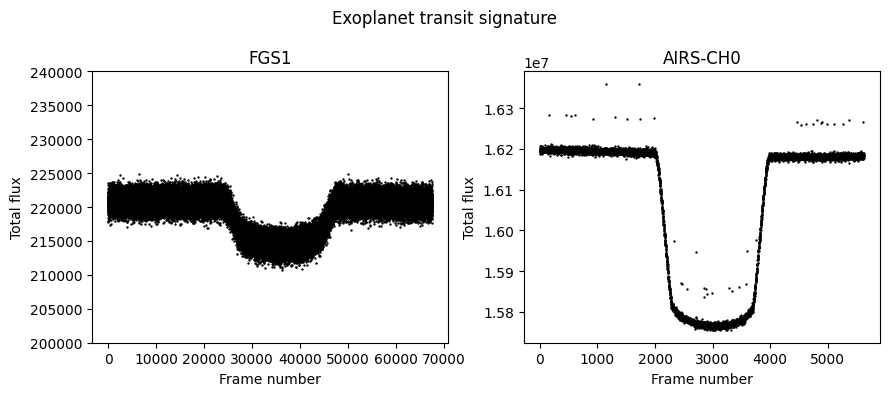

In [25]:
total_fgs_flux = [np.sum(frame) for frame in fgs_signal]
total_airs_flux = [np.sum(frame) for frame in airs_signal]

fig, axs = plt.subplots(1, 2, figsize=(config.STD_FIG_WIDTH*1.5, 4))
fig.suptitle('Exoplanet transit signature')

axs[0].set_title('FGS1')
axs[0].scatter(list(range(len(total_fgs_flux))), total_fgs_flux, color='black', s=0.5)
axs[0].set_xlabel('Frame number')
axs[0].set_ylabel('Total flux')
axs[0].set_ylim(200000, 240000) 

axs[1].set_title('AIRS-CH0')
axs[1].scatter(list(range(len(total_airs_flux))), total_airs_flux, color='black', s=0.5)
axs[1].set_xlabel('Frame number')
axs[1].set_ylabel('Total flux')

fig.tight_layout()

plt.savefig(
    f'{figures_dir}/02.1.9-corrected_CDS_transits.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)


Nice! Better than expected. I thought it would be harder to spot the transit in the AIRS-CHO data, but it's cleaner than the FGS1 trace. I guess it is a science instrument, not just an alignment camera... But we are still dealing with a tiny fraction of the total signal. The transit signature is a ~2.5% dip in the AIRS-CH0 data whereas for the GFS1 data, it's 1.5%.

## 5. Summary

Now my concern is time. The six step preprocessing pipeline takes a long time for one planet. We can easily parallelize it - but the Kaggle notebook that we will have to run in only has 4 cores. The good news is we clearly don't need to take the extra step of using the FGS1 data as a proxy to spot the transit and then get the corresponding time points from the AIRS-CH0 data. Still thinking we should down sample the FGS1 data so we have matched time series.

Here's the new plan:

1. **Refactor preprocessing** - I think we should be looking at one module for upload to Kaggle to keep the final notebook clean and things simple-ish (the other crazy idea is to make it an installable package on PyPI...).
2. **Re-sample FGS data** - keep only time points that are also represented in the AIRS data. It's not like we are going to miss the transit or something, and it will cut the amount of data way down. The example preprocessing function uses binning with sum - but I don't like that.
3. Figure out how to reliably crop the signals.
4. Figure out how to select a transit and non-transit window from each time series for normalization

Profit? Note: 2, 3, and/or 4 could be done first in the pipeline. They each will reduce the amount of data significantly and in turn speed up the rest of the preprocessing. But, it may be harder to select signal or transits from the un-corrected data. Will have to think about order of operations a bit more as we see each step take shape.